# Initialisations

In [1]:
library(ggplot2)
library(corrplot)
library(cluster)
library(reshape2)
theme_set(theme_classic())

corrplot 0.84 loaded


# Plot Functions

In [18]:
adenome_scatterplot <- function(df, feature_1, feature_2, f1, f2) {
  x_axis = f1
  y_axis = f2
  title = paste(x_axis, " Vs. ", y_axis)
  g <- ggplot(df, aes(x=feature_1, y=feature_2))
  g <- g + geom_point()
  g <- g + labs(title=title,y=y_axis,x=x_axis)
  print(g)
}

# Obtenir le triangle inférieur d'une matrice
get_lower_tri <- function(mat){
    mat[upper.tri(mat)] <- NA
    return(mat)
}

# Obtenir le triangle supérieur d'une matrice
get_upper_tri <- function(mat){
    mat[lower.tri(mat)] <- NA
    return(mat)
}

# Re-ordonne la matrice de corrélation
reorder_cormat <- function(cormat){
    # Utiliser la corrélation entre les variables
    # comme mesure de distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <- cormat[hc$order, hc$order]
}

adenome_heatmap <- function(cormat) { 
    # Reordonner la matrice de corrélation
    cormat <- reorder_cormat(cormat)
    upper_tri <- get_upper_tri(cormat)
    # Fondre la matrice de corrélation
    melted_cormat <- melt(upper_tri, na.rm = TRUE)
    # Créer le heatmap
    ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
        geom_tile(color = "white")+
        scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
        midpoint = 0, limit = c(-1,1), space = "Lab",
        name="Pearson\nCorrelation") +
        theme_minimal()+ # minimal theme
        theme(axis.text.x = element_text(angle = 45, vjust = 1, 
        size = 12, hjust = 1))+
        coord_fixed()
    
    ggheatmap <- ggheatmap + 
    geom_text(aes(Var2, Var1, label = round(value,3)), color = "black", size = 3) +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank(),
      axis.ticks = element_blank(),
      legend.justification = c(1, 0),
      legend.position = c(0.6, 0.7),
      legend.direction = "horizontal")+
      guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))
    
    # Afficher heatmap
    print(ggheatmap)
}

# Import du dataset complet et cast

In [3]:
# import du fichier complet
rtupb_vbpps_complete <- read.csv(file = "datasets/RTUPB-VBPPS.csv", sep = ",")

In [4]:
# Cast des variables booléennes
rtupb_vbpps_complete$Comorbidite<-as.logical(rtupb_vbpps_complete$Comorbidite)
rtupb_vbpps_complete$Porteur_Sonde<-as.logical(rtupb_vbpps_complete$Porteur_Sonde)
rtupb_vbpps_complete$Caillotage<-as.logical(rtupb_vbpps_complete$Caillotage)
rtupb_vbpps_complete$Transfusion<-as.logical(rtupb_vbpps_complete$Transfusion)
rtupb_vbpps_complete$Reprise_Bloc<-as.logical(rtupb_vbpps_complete$Reprise_Bloc)

# Cast des variables catégoriques
rtupb_vbpps_complete$Indication<-as.factor(rtupb_vbpps_complete$Indication)
rtupb_vbpps_complete$Anesthesie<-as.factor(rtupb_vbpps_complete$Anesthesie)
rtupb_vbpps_complete$Evenement<-as.factor(rtupb_vbpps_complete$Evenement)
rtupb_vbpps_complete$Technique<-as.factor(rtupb_vbpps_complete$Technique)

# Cast des variables catégoriques ordonnées
rtupb_vbpps_complete$QoL<-as.ordered(rtupb_vbpps_complete$QoL)
rtupb_vbpps_complete$X1M_QoL<-as.ordered(rtupb_vbpps_complete$X1M_QoL)
rtupb_vbpps_complete$X3M_QoL<-as.ordered(rtupb_vbpps_complete$X3M_QoL)
rtupb_vbpps_complete$X6M_QoL<-as.ordered(rtupb_vbpps_complete$X6M_QoL)
rtupb_vbpps_complete$X9M_QoL<-as.ordered(rtupb_vbpps_complete$X9M_QoL)
rtupb_vbpps_complete$X12M_QoL<-as.ordered(rtupb_vbpps_complete$X12M_QoL)
rtupb_vbpps_complete$X15M_QoL<-as.ordered(rtupb_vbpps_complete$X15M_QoL)
rtupb_vbpps_complete$X18M_QoL<-as.ordered(rtupb_vbpps_complete$X18M_QoL)

# 1. Considérations

Les individus porteur de sonde ne sont pas concernés par la variable 'Résidu post mictionnel'. Ils n'ont donc pas de valeurs pour cette feature. 
Ici, plusieurs scénarios sont possibles. On pourrait, par exemple, enlever la variable 'Résidu post mictionnel' ou alors baser notre analyse sur les patients qui ne sont pas porteurs de sonde uniquement.

Tentons de voir si cette variable a de l'importance.
Commençons par étudier les corrélations de celle-ci pour tous les individus non porteur de sonde.

In [5]:
# On crée un dataframe ne comportant que les variables numériques et auquel on soustrait les individus porteurs de sonde
rtupb_vbpps_pre_num <- rtupb_vbpps_complete[,sapply(rtupb_vbpps_complete, function(x) is.numeric(x))][which(rtupb_vbpps_complete$Porteur_Sonde == FALSE),]
# Le volume réséqué comporte des NA que nous enlevons pour la matrice des corrélations
# Nous enlevons également les variables post-opératoire
rtupb_vbpps_pre_num <- subset(rtupb_vbpps_pre_num, select=-c(Volume_Reseque))[,1:9]

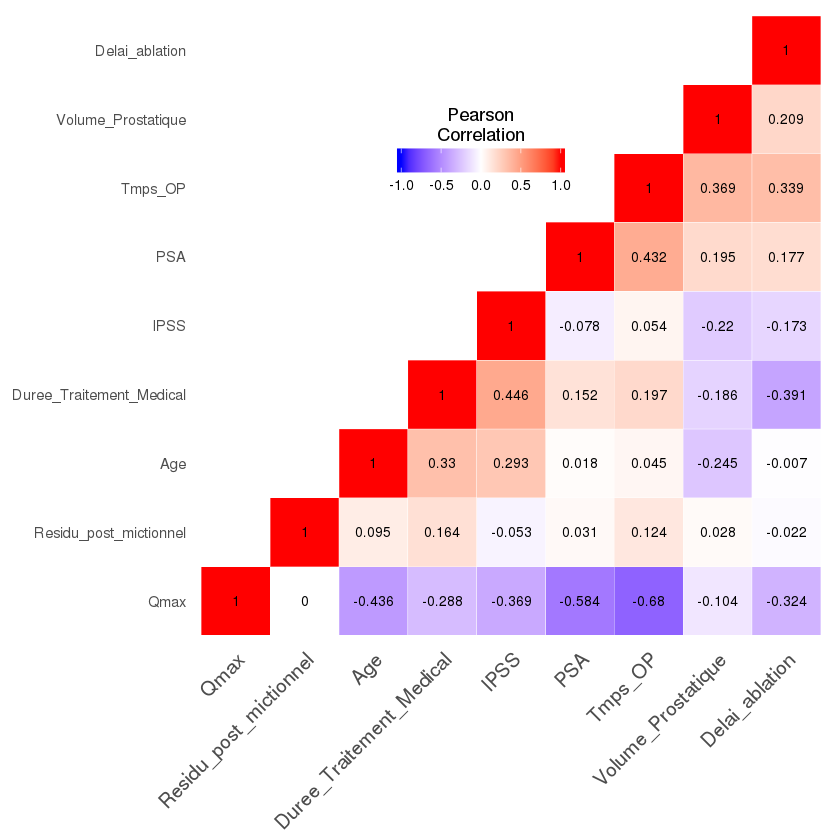

In [6]:
mat_cor = cor(rtupb_vbpps_pre_num, method = c("pearson"))
adenome_heatmap(mat_cor)

On peut voir que la variable 'Résidu post mictionnel' est très peu corrélée avec les autres dimensions. Cela signifie qu'elle apporte de l'information au jeu de données.

Nous pouvons vérifier cette hypothèse en faisant une ACP avec uniquement les individus qui ne sont pas porteur de sonde.

In [7]:
# on fait la PCA
pca <- stats::prcomp(x=rtupb_vbpps_pre_num)
pca

Standard deviations (1, .., p=9):
[1] 96.682404 33.677496 11.847016  8.483832  5.840328  4.906471  2.667482
[8]  1.805027  1.186587

Rotation (n x k) = (9 x 9):
                                   PC1         PC2         PC3           PC4
Age                       0.0090742206 -0.08620869 -0.05063096  0.8965109212
Duree_Traitement_Medical  0.0652208791 -0.98658148 -0.04601801 -0.1198556433
IPSS                     -0.0024868692 -0.08107251 -0.02518155  0.1843549293
Qmax                     -0.0003333612  0.03914001 -0.22121998 -0.2339805797
PSA                       0.0008206094 -0.01024102  0.08442209  0.0027965571
Volume_Prostatique        0.0017846847  0.04231588  0.34461275 -0.2846259915
Residu_post_mictionnel    0.9977106086  0.06601678 -0.01089900 -0.0008294484
Tmps_OP                   0.0150585627 -0.06471457  0.90147824  0.0953359047
Delai_ablation           -0.0007227770  0.02605103  0.08414050  0.0553149416
                                  PC5         PC6          PC7       

La PCA confirme que la feature 'Résidu post mictionnel' a 1 poids important dans le jeu de données. Elle sera plus discriminante que les autres features. Il nous semble donc important de la considérer.

Une autre intuition nous dit que les porteurs de sonde sont surtout les personnes âgées. On peut le vérifier sur le jeu complet avec le tableau de contingence et le boxplot ci-dessous.

       
        57 58 59 60 61 62 64 65 66 67 68 70 71 73 74 75 77 78 79 80 81 82 83 84
  FALSE  4  2  1  3  2  3  3  3  4  1  2  0  0  0  0  4  4  2  0  0  1  0  1  0
  TRUE   0  0  0  0  0  0  0  0  0  2  0  3  2  1  2  1  0  0  1  3  3  3  1  4
       
        85 86
  FALSE  1  1
  TRUE   0  0

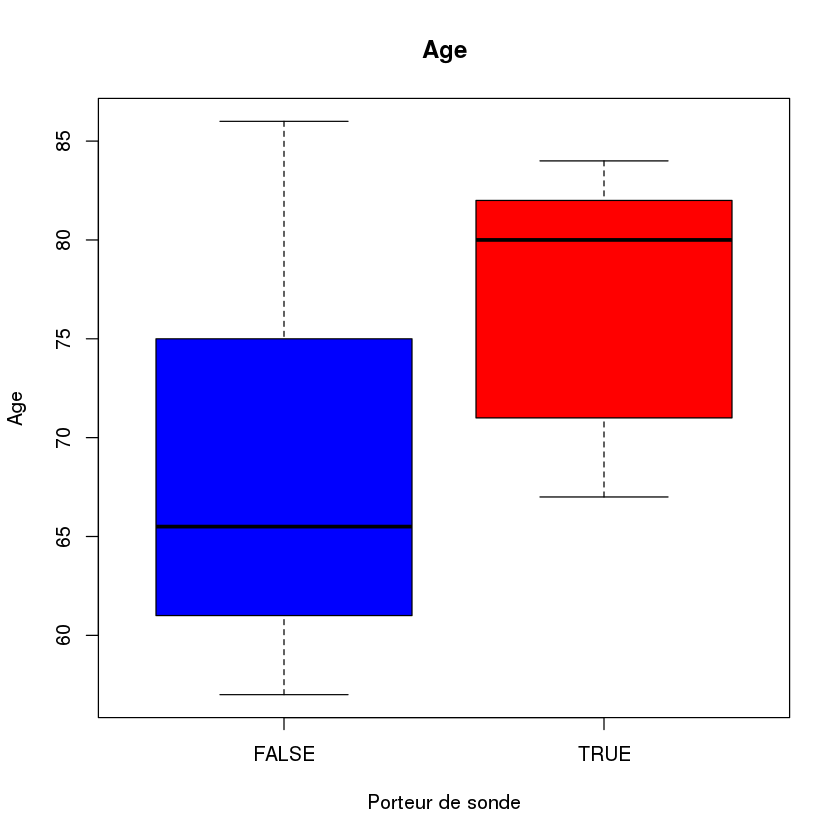

In [8]:
table(rtupb_vbpps_complete$Porteur_Sonde, rtupb_vbpps_complete$Age)

boxplot(Age~Porteur_Sonde,data=rtupb_vbpps_complete, main="Age", xlab="Porteur de sonde", ylab="Age", col=c("blue","red"))

Cette constation ajoutée à la constation précédente que la variable 'Résidu post mictionnel' a de l'importance dans l'étude de la population des non porteurs de sonde, nous faisons le choix de ne pas retenir les individus porteurs de sonde.
La suite de notre analyse se fera sur les malades non porteurs de sonde. Cette sous-population représente un peu plus de 60% de la population totale (41 individus sur 68).

De plus le volume réséqué n'est disponible que pour la technique opératoire RTUPB. Nous pensons que cette donnée va fausser l'analyse et ne sera pas pertinente dans la discrimination des techniques opératoires. Nous faisons le choix de la supprimer du jeu de données.

Enfin, certaines variables sont constantes à tout le tableau : 'Evenement', 'Transfusion' et 'Reprise Bloc'. Nous faisons le choix de les supprimer également du jeu de données, elles n'apporteront pas d'information utile.

Résumé : Jeu de données complet 
   \- moins Porteurs de sonde
   \- moins Volume Réséqué
   \- moins Evenement
   \- moins Transfusion
   \- moins Reprise Bloc

# Préparation du jeu de données

In [9]:
# on garde uniquement les individus non porteur de sonde
# La variable Porteur_Sonde devient donc inutile
# on supprime aussi les features que nous avons choisies d'ignorer
rtupb_vbpps <- subset(rtupb_vbpps_complete[which(rtupb_vbpps_complete$Porteur_Sonde == FALSE),],select=-c(Porteur_Sonde,Volume_Reseque,Evenement,Transfusion,Reprise_Bloc))

In [10]:
# 15 premières colonnes du dataset -> pré-opératoire, les dernières -> post-opératoire
rtupb_vbpps_pre <- rtupb_vbpps[,1:15]
rtupb_vbpps_post <- rtupb_vbpps[,16:36]

In [11]:
# On crée un dataframe ne comportant que les variables numériques (pour corrélation linéaire de Pearson)
rtupb_vbpps_num <- rtupb_vbpps[,sapply(rtupb_vbpps, function(x) is.numeric(x))]
rtupb_vbpps_pre_num = rtupb_vbpps_pre[,sapply(rtupb_vbpps_pre, function(x) is.numeric(x))]
rtupb_vbpps_post_num = rtupb_vbpps_post[,sapply(rtupb_vbpps_post, function(x) is.numeric(x))]

# On crée un dataframe ne comportant que les données booléennes, ordinales ou catégoriques
rtupb_vbpps_cat <- rtupb_vbpps[,sapply(rtupb_vbpps, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]
rtupb_vbpps_pre_cat = rtupb_vbpps_pre[,sapply(rtupb_vbpps_pre, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]
rtupb_vbpps_post_cat = rtupb_vbpps_post[,sapply(rtupb_vbpps_post, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]

# 2. Analyse descriptive

## 2.1 Pré-opératoire

### 2.1.2 Distributions

In [12]:
# on divise le dataset en 2 pour voir les techniques séparément
rtupb_pre <- rtupb_vbpps_pre[which(rtupb_vbpps_pre$Technique == 1),]
vbpps_pre <- rtupb_vbpps_pre[which(rtupb_vbpps_pre$Technique == 2),]

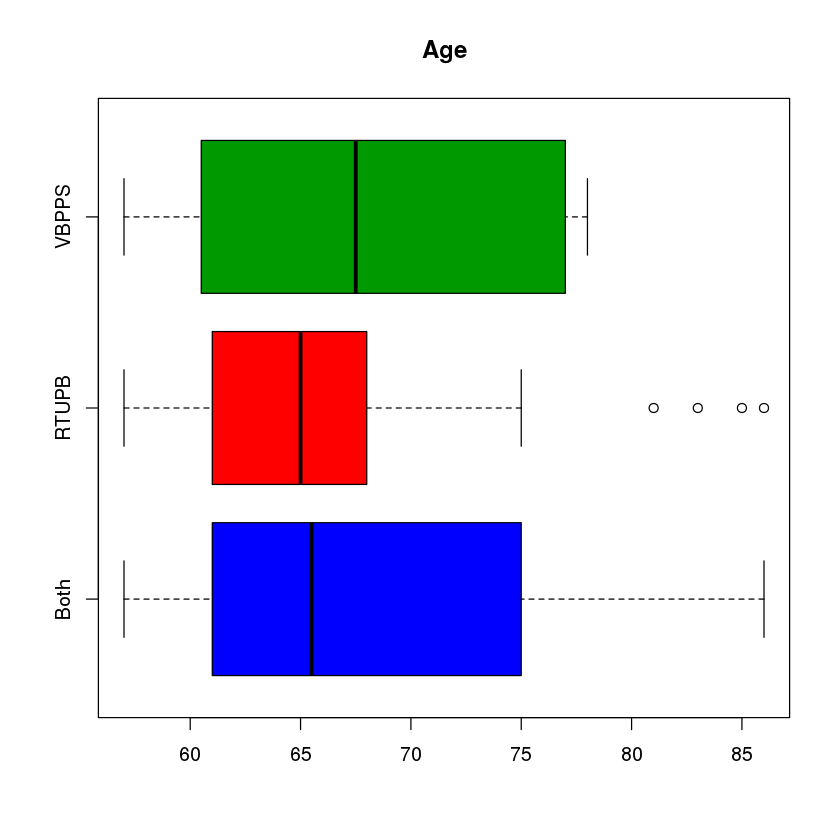

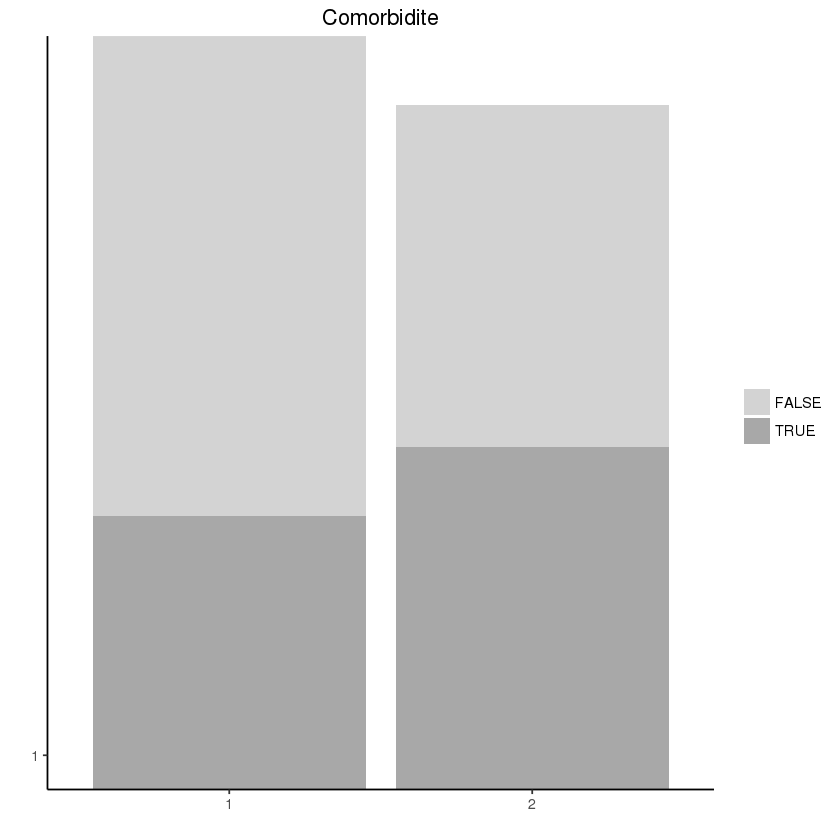

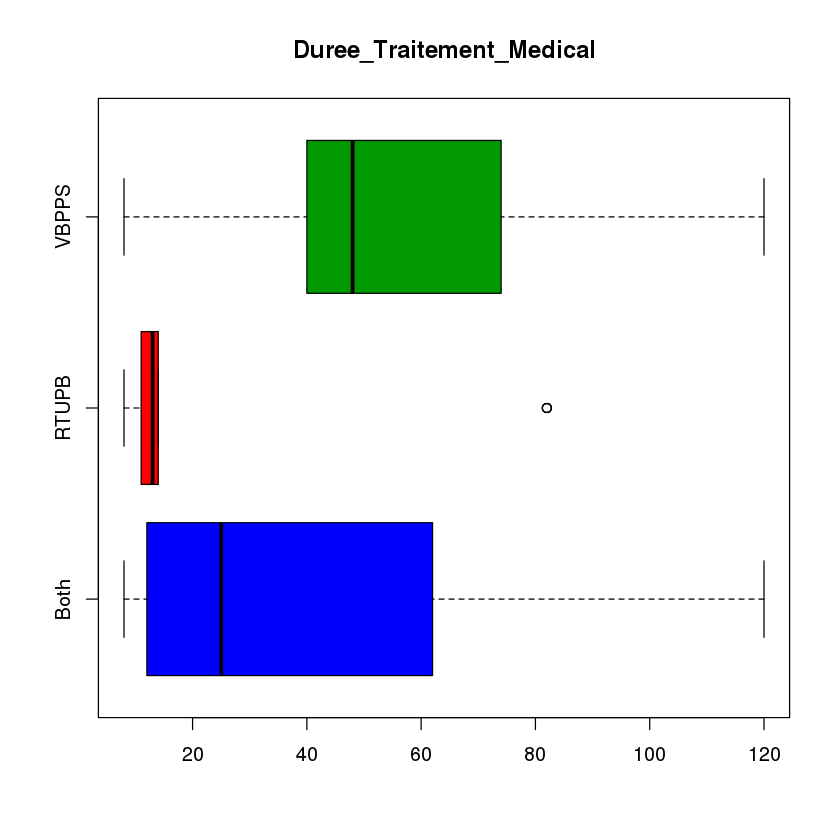

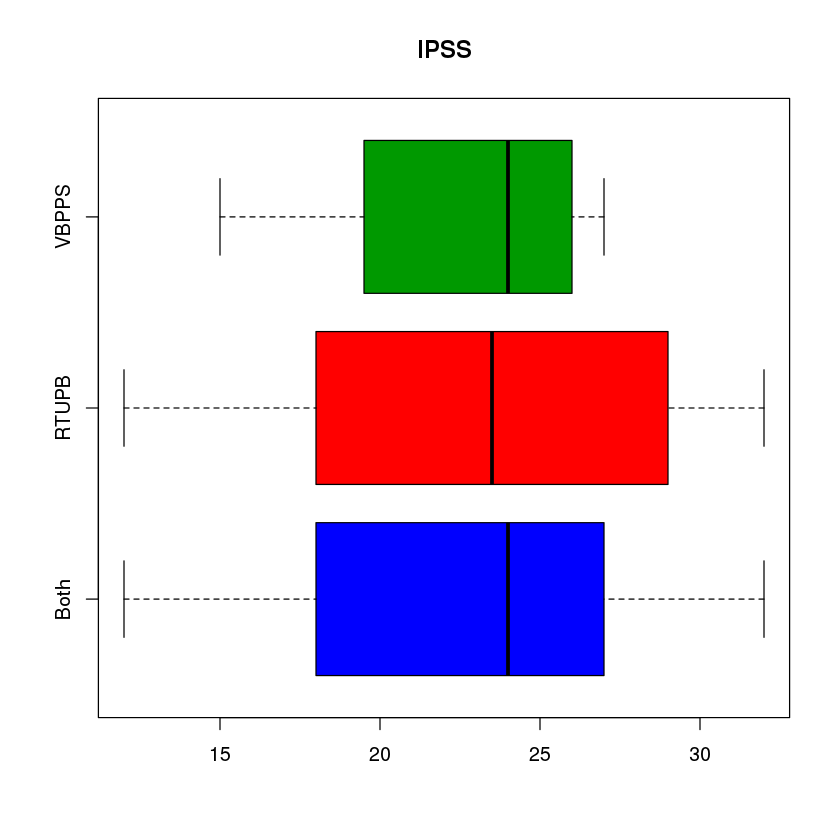

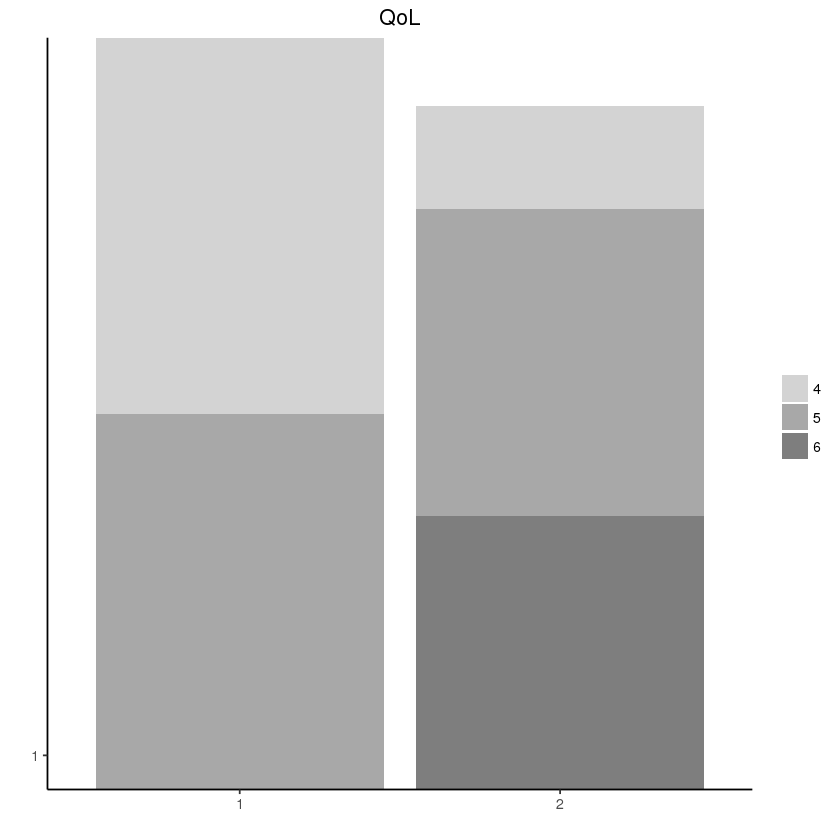

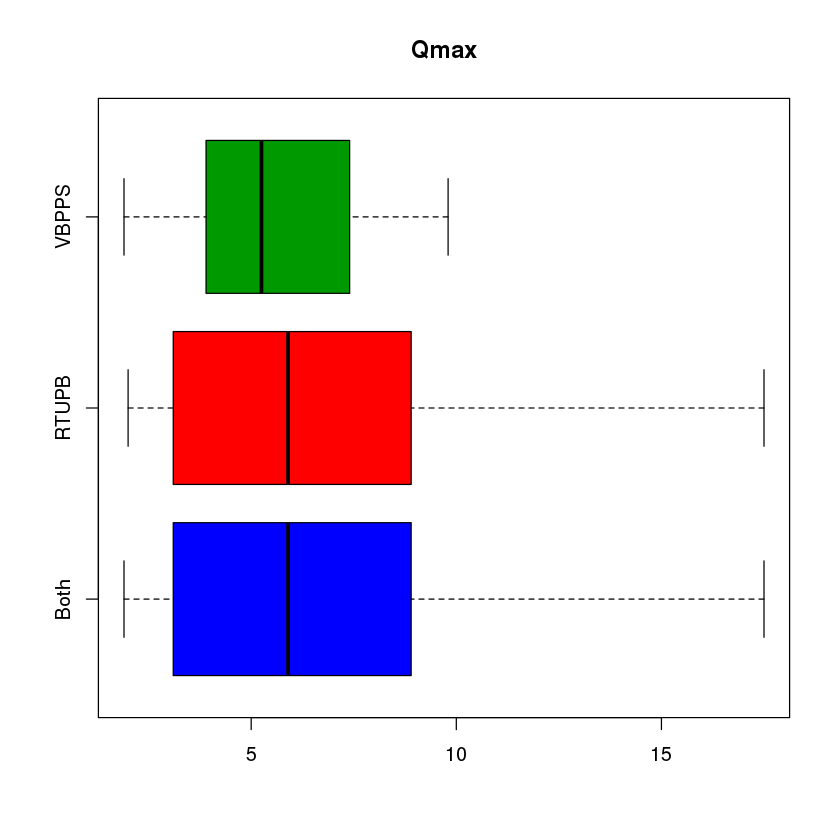

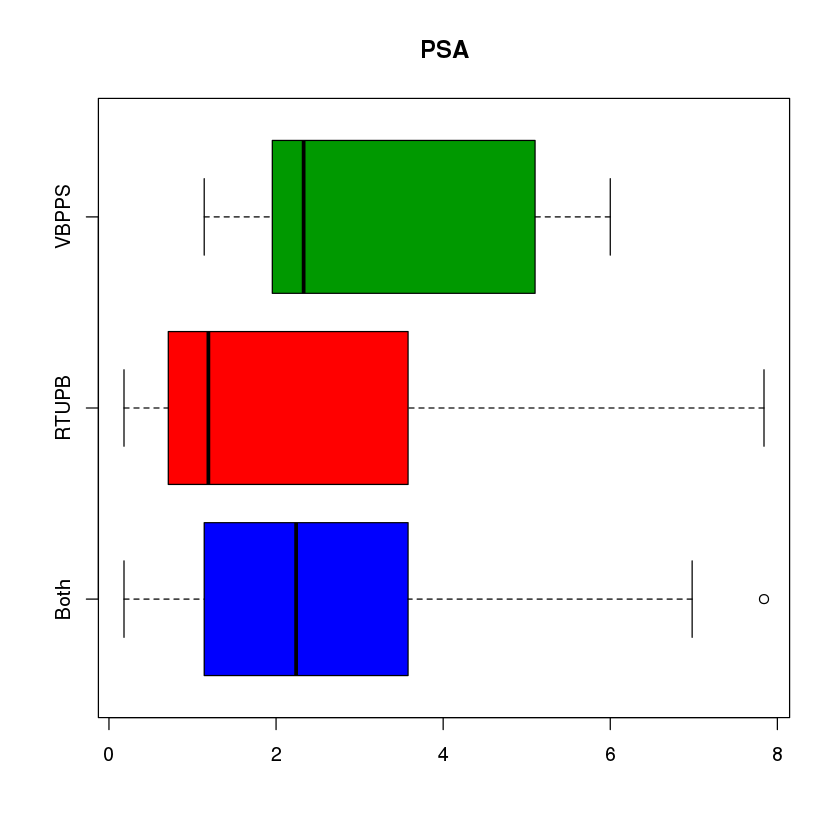

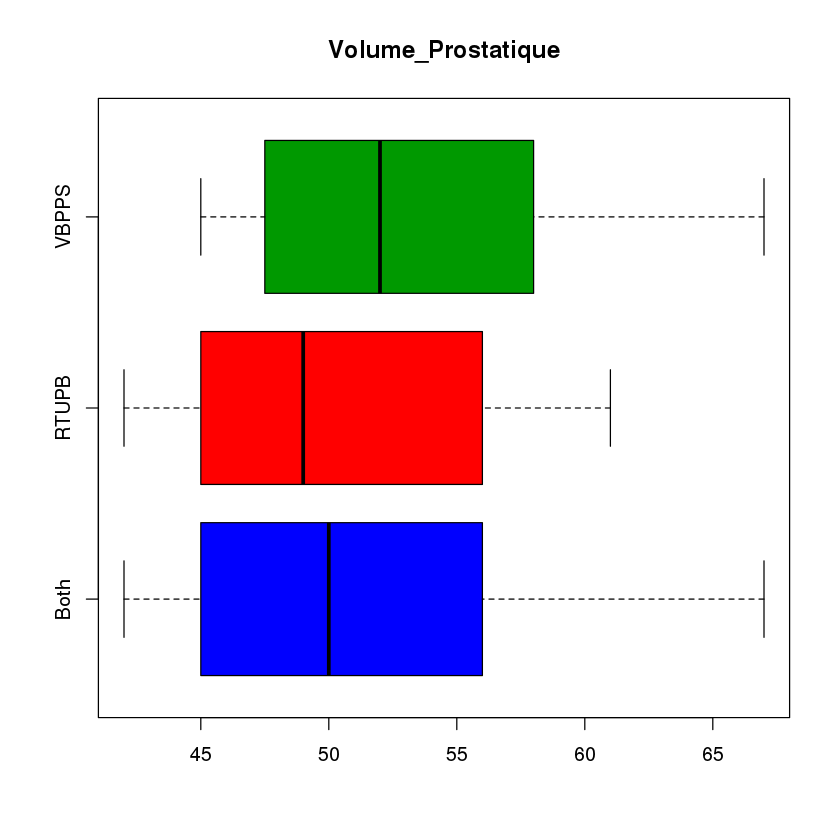

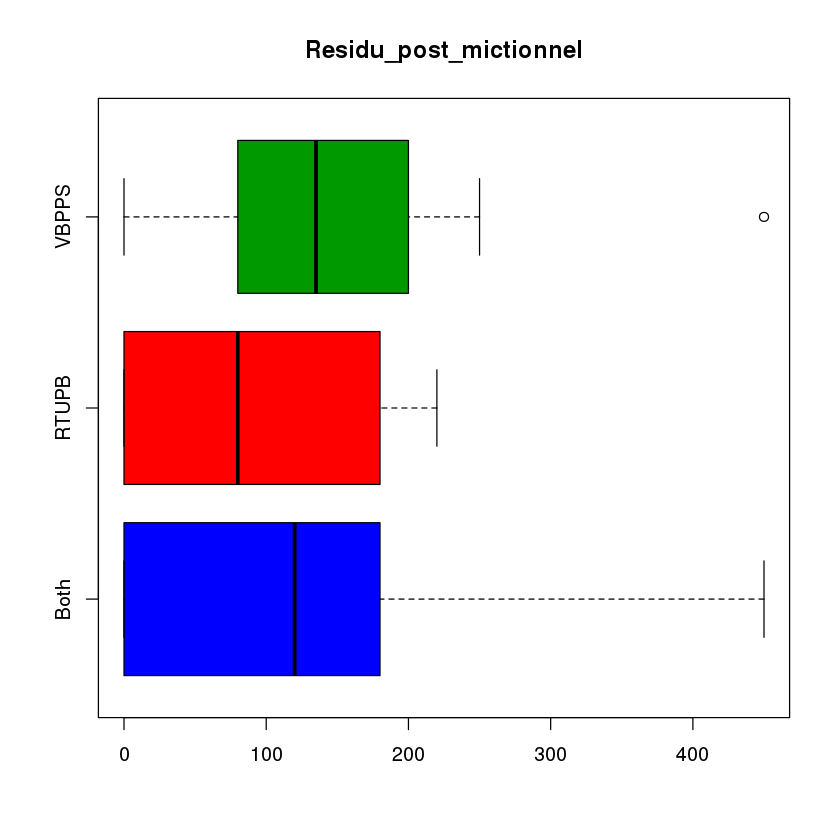

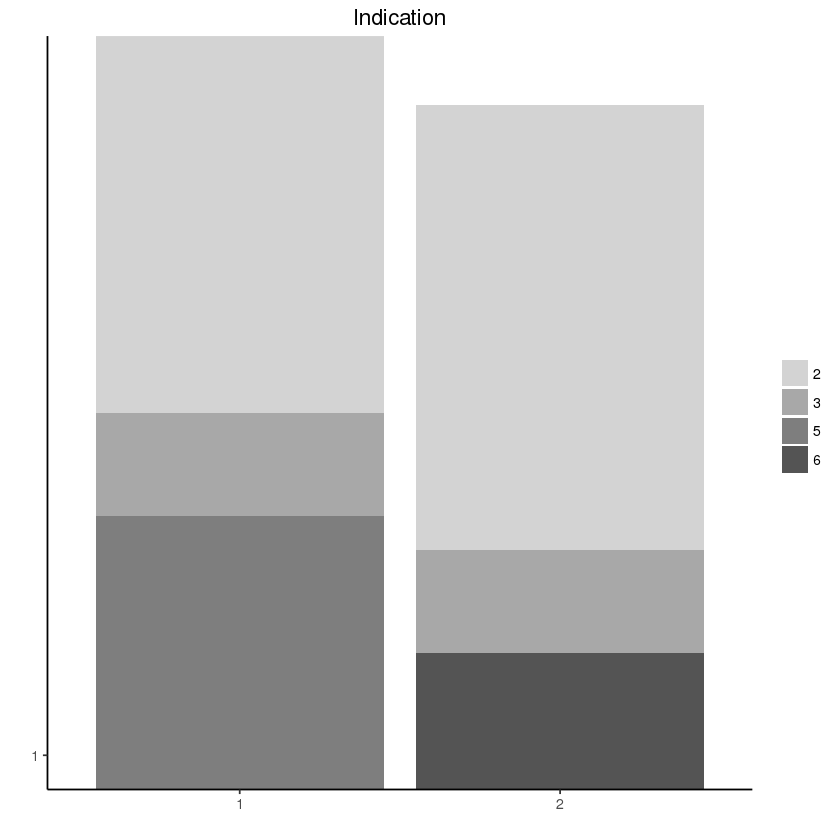

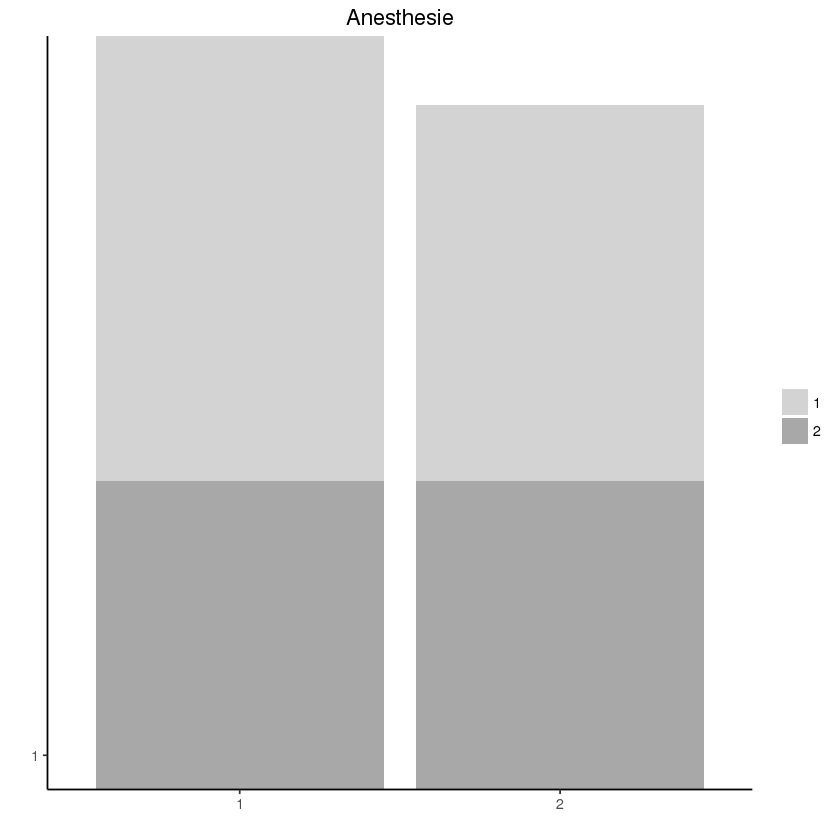

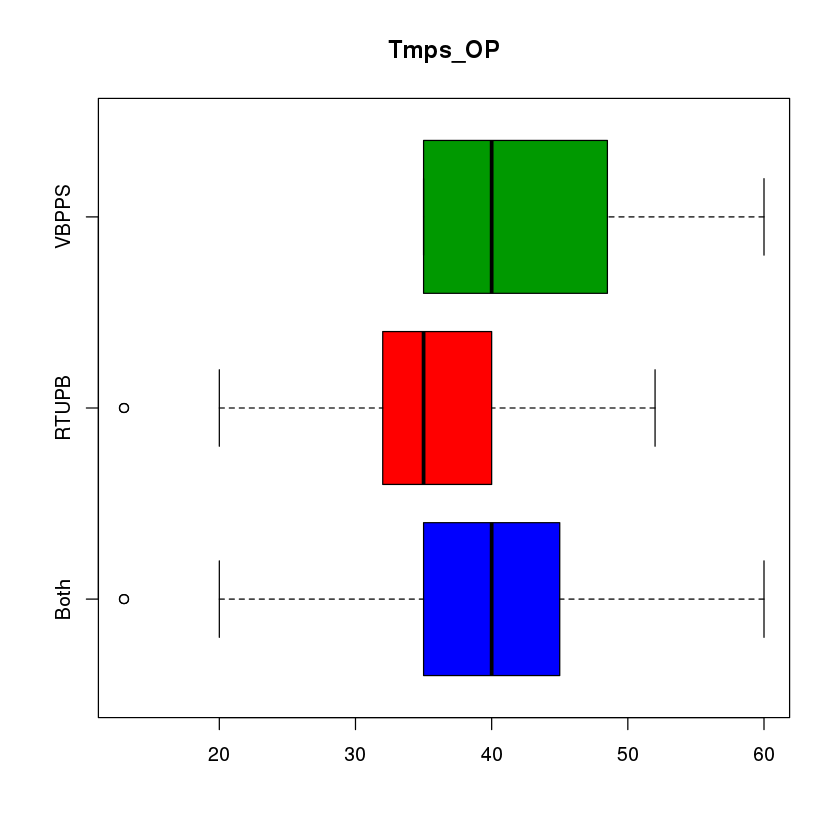

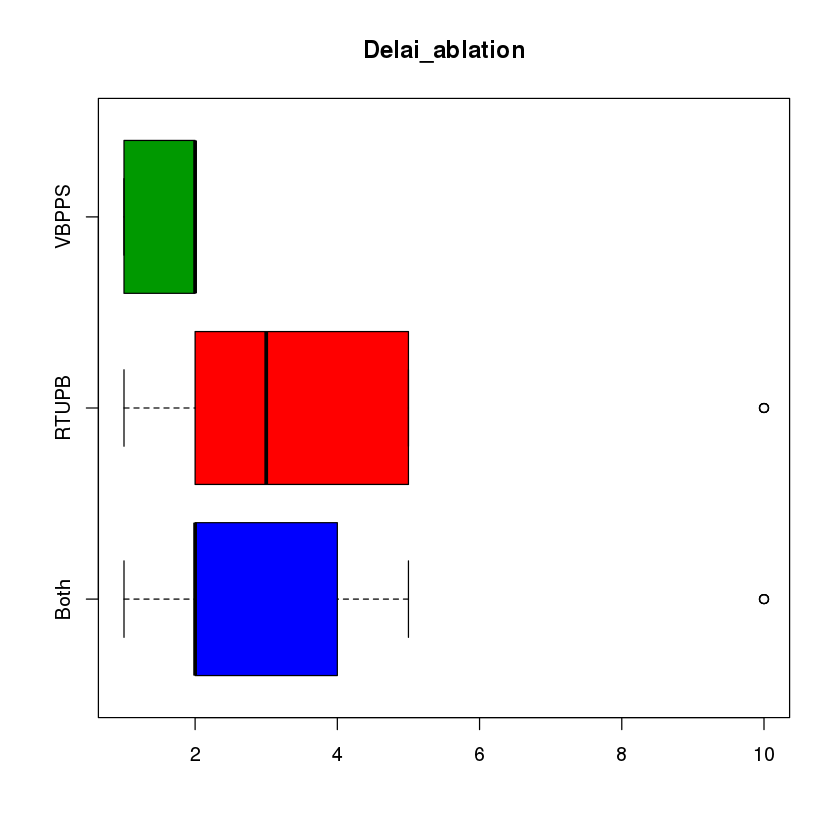

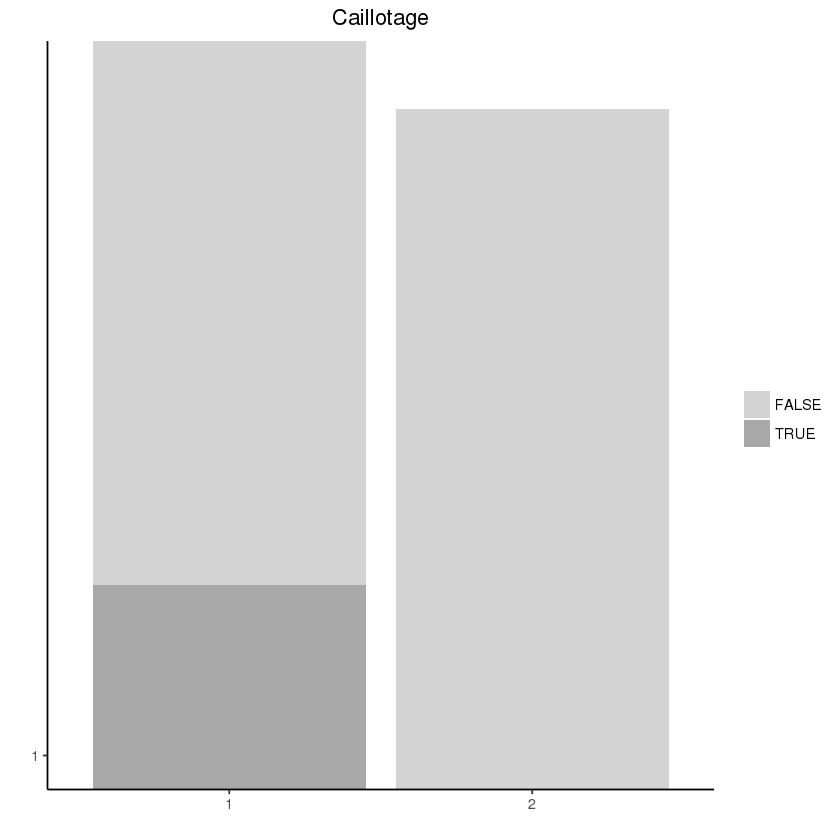

In [13]:
# Barplots des variables catégoriques
fill <- c("#d3d3d3", "#a8a8a8", "#7e7e7e", "#545454", "#2a2a2a")

for (i in 1:ncol(rtupb_vbpps_pre)) {
    # Boxplots des variables numériques
    if (is.numeric(rtupb_vbpps_pre[,i]))
        boxplot(rtupb_vbpps_pre[,i], rtupb_pre[,i], vbpps_pre[,i],
            names=c("Both","RTUPB","VBPPS"),horizontal=TRUE,main=colnames(rtupb_vbpps_pre)[i], col=c("blue","red","#009900"))
    else
        if (colnames(rtupb_vbpps_pre)[i] != "Technique"){
            # Stacked barplots des variables catégoriques
            p4 <- ggplot() + geom_bar(aes(y = factor(1), x = Technique, fill = rtupb_vbpps_pre[,i]), data = rtupb_vbpps_pre,
                stat="identity") +
                theme(legend.title = element_blank(), plot.title = element_text(hjust = 0.5)) +
                scale_fill_manual(values=fill) + labs(x="", y="") + ggtitle(colnames(rtupb_vbpps_pre)[i])
            print(p4)
    }
}

### 2.1.3 Corrélations

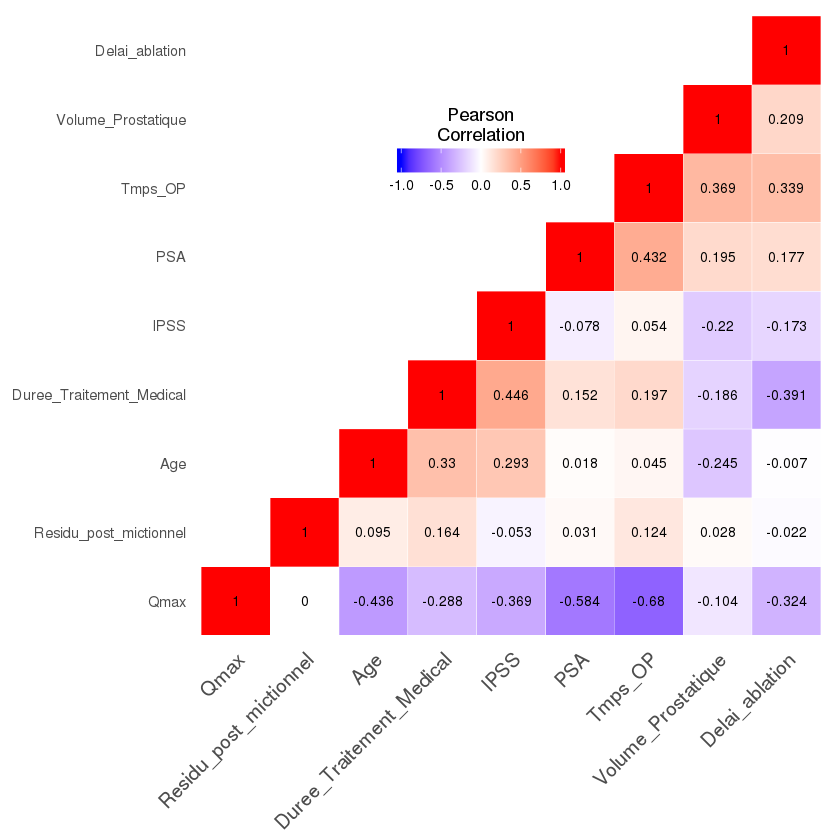

In [14]:
mat_cor = cor(rtupb_vbpps_pre_num, method = c("pearson"))
adenome_heatmap(mat_cor)


Pour les techniques RTUPB-VBPSS, en pré-opératoire, nous notons une faible corrélation négative entre Qmax et les variables suivantes :
- Temps opératoire
- PSA

On déduit que meilleure est la miction, moins il y a d'antigène prostatique dans le sang (PSA). Une augmentation du PSA est symptome d'un cancer de la prostate.
Plus la miction est bonne, moins le temps opératoire est long.

Voici les scatterplots de ces croisements de variables.

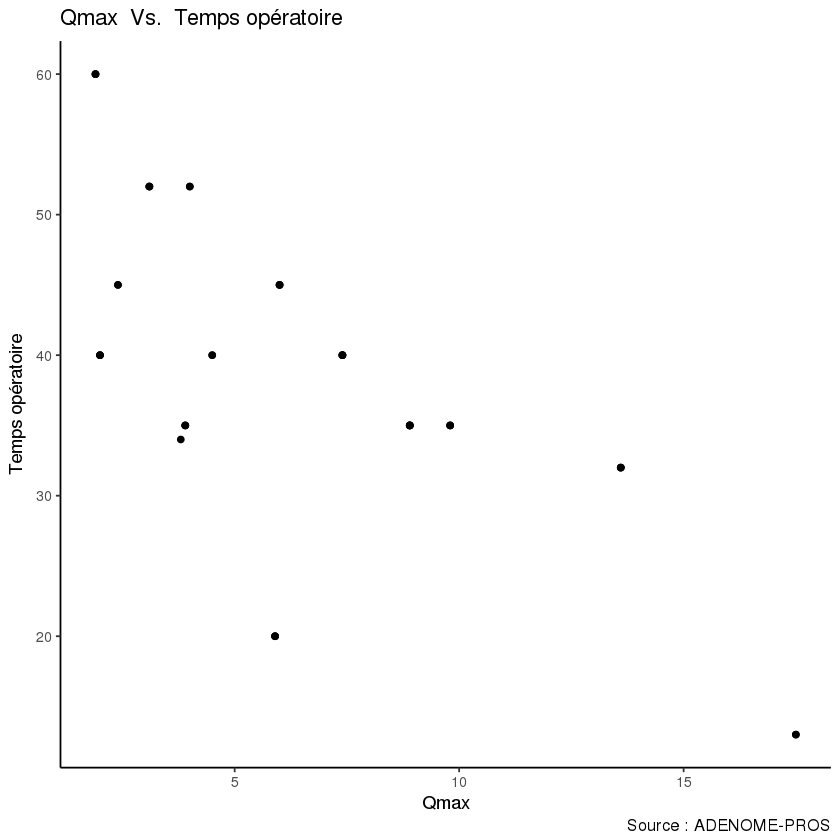

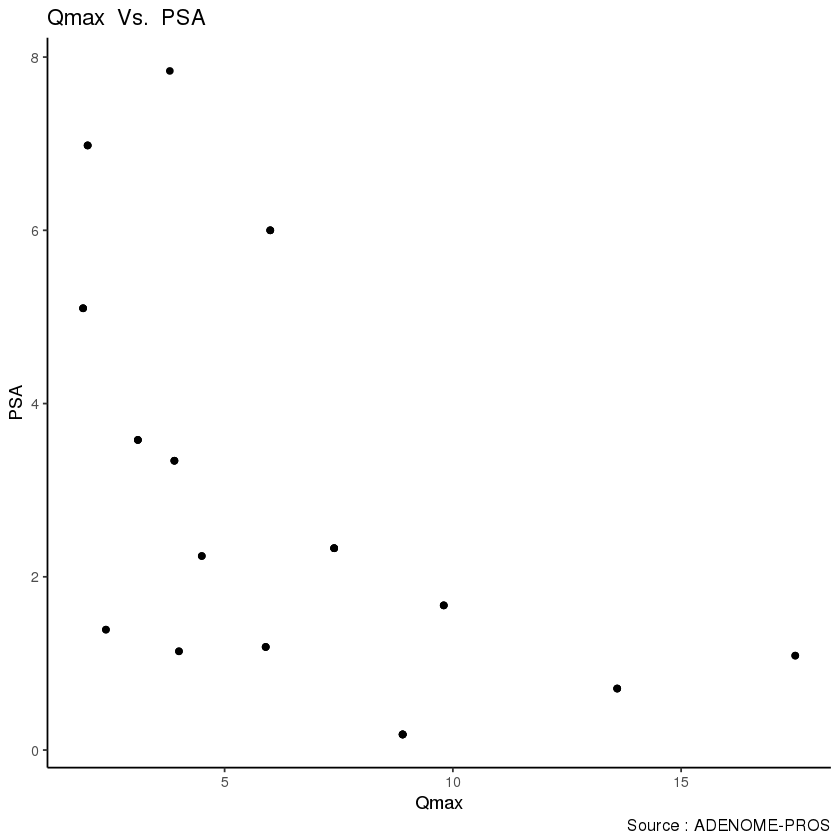

In [15]:
adenome_scatterplot(rtupb_vbpps_pre_num,rtupb_vbpps_pre_num$Qmax,rtupb_vbpps_pre$Tmps_OP,"Qmax","Temps opératoire")
adenome_scatterplot(rtupb_vbpps_pre,rtupb_vbpps_pre$Qmax,rtupb_vbpps_pre$PSA,"Qmax","PSA")

Nous notons aussi 1 corrélation positive entre l'IPSS et la durée du traitement médical. Plus les symptômes sont importants (IPSS), plus la durée de traitement est longue.

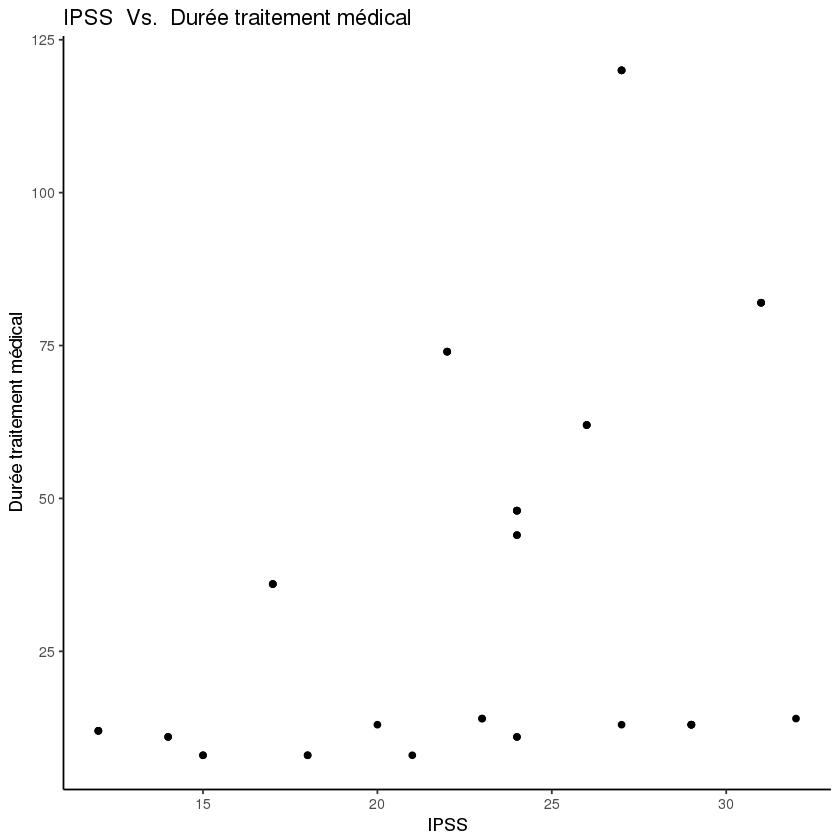

In [20]:
adenome_scatterplot(rtupb_vbpps_pre,rtupb_vbpps_pre$IPSS,rtupb_vbpps_pre$Duree_Traitement_Medical,"IPSS","Durée traitement médical")

On remarque plusieurs individus dans la partie basse et droite de la courbe qui ne semblent pas suivre cette tendance.

### 2.1.4 Analyse en composantes principales

In [21]:
pca <- stats::prcomp(x=rtupb_vbpps_pre_num)
summary(pca)

Importance of components%s:
                           PC1     PC2      PC3     PC4     PC5     PC6     PC7
Standard deviation     96.6824 33.6775 11.84702 8.48383 5.84033 4.90647 2.66748
Proportion of Variance  0.8684  0.1054  0.01304 0.00669 0.00317 0.00224 0.00066
Cumulative Proportion   0.8684  0.9738  0.98681 0.99350 0.99667 0.99891 0.99957
                          PC8     PC9
Standard deviation     1.8050 1.18659
Proportion of Variance 0.0003 0.00013
Cumulative Proportion  0.9999 1.00000

In [22]:
sum(100 * (pca$sdev^2)[1:2] / sum(pca$sdev^2))

[1] 97.37744

Ainsi les deux premières composantes à elles seules représentent 97.4% de l'information.

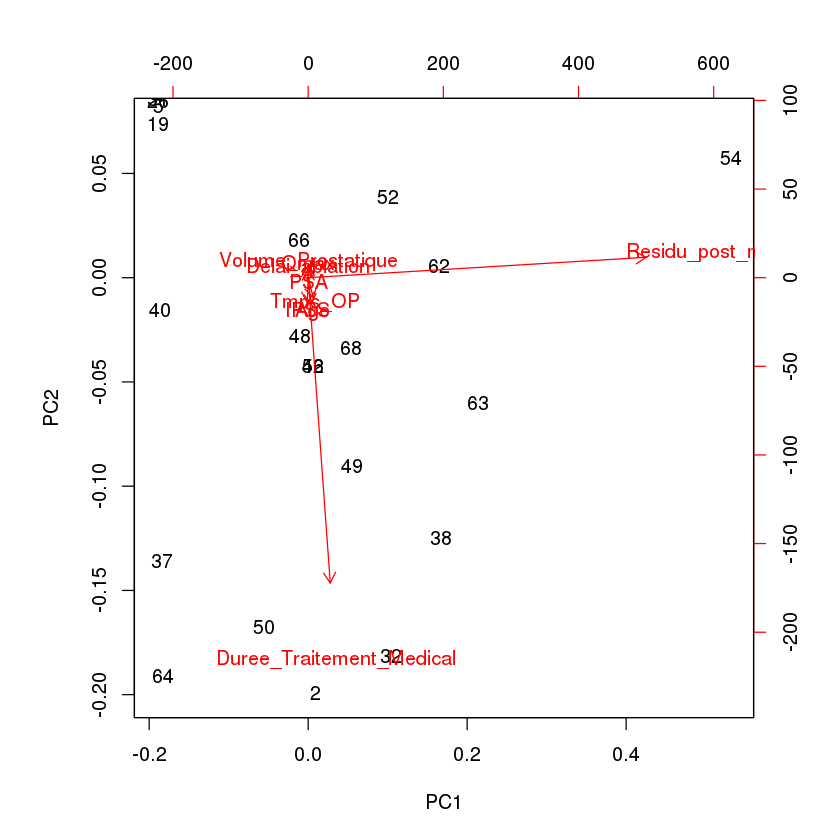

In [24]:
biplot(pca,ylim=c(-0.2,0.075),scale=TRUE)

La durée du traitement est indépendante du résidu post mictionnel. Le résidu post mictionnel n'est pas dépendant des autres variables.
Le résidu post mictionnel et la durée du traitement médical sont 2 variables d'importance. Nous verrons par la suite ce qu'elles nous apportent.

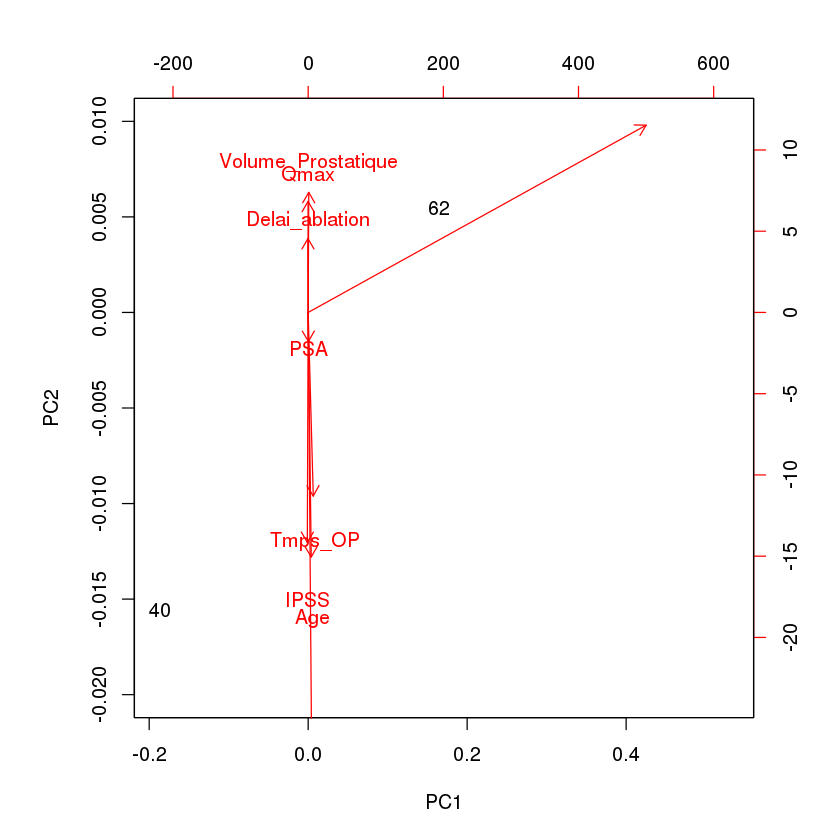

In [27]:
biplot(pca,ylim=c(-0.02,0.01),scale=TRUE)

Le volume prostatique, le délai d'ablation et le débit maximal urinaire sont corrélés. Il est étrange de constater que le débit maximal urinaire (synonyme d'une bonne miction qui peut laisser penser que c'est positif) augmente en même temps que le volume prostatique (signal négatif).
Le taux d'antigène prostatique, le temps de l'opération, le nombre de symptômes et l'age sont corrélés. Plus l'âge est important, plus les signaux permettant d'identifier un adénome sont importants et plus le temps de l'opération est élevé.

## 2.2 Post-opératoire

### 2.2.1 Distributions

In [ ]:
# Boxplots des variables numériques et barplots des variables catégoriques

for (i in 1:ncol(rtupb_post)) {
  if (is.numeric(rtupb_post[,i]) || is.integer(rtupb_post[,i])) {
    adenome_boxplot(rtupb_post,i,"RTUPB-VBPSS Post-operatoire")
  }
  else
    adenome_barplot(rtupb_post,i,"RTUPB-VBPSS Post-operatoire")
}

In [ ]:
### .2.2.2 Corrélations entre les variables Post-Opératoire

In [ ]:
plot(rtupb_cat_post)
plot(rtupb_num_post)